In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import datetime

# --- Load and clean data ---
df = pd.read_csv('es-30.txt')
df.columns = df.columns.str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df.drop(columns=['date', 'time'], inplace=True)

# --- Filter for full 13-bar days ---
expected_bars_per_day = 13
valid_df = df.groupby(df.index.date).filter(lambda x: len(x) == expected_bars_per_day)
valid_dates = pd.Series(valid_df.index.date).unique()
valid_dates.sort()


def build_tpo_distribution(df, sample_date, price_bin_size=0.25):
    day_data = df[df.index.date == sample_date]
    if len(day_data) != 13:
        return None

    low = day_data['low'].min()
    high = day_data['high'].max()
    price_bins = np.arange(low, high + price_bin_size, price_bin_size)
    price_levels = price_bins[:-1]

    bracket_letters = list("ABCDEFGHIJKLM")
    tpo_matrix = {price: [] for price in price_levels}

    for i, (_, row) in enumerate(day_data.iterrows()):
        bracket = bracket_letters[i]
        bar_range = np.arange(row['low'], row['high'] + price_bin_size, price_bin_size)
        indices = np.digitize(bar_range, price_bins) - 1
        for idx in indices:
            if 0 <= idx < len(price_levels):
                price = price_levels[idx]
                if bracket not in tpo_matrix[price]:
                    tpo_matrix[price].append(bracket)

    tpo_counts = [len(tpo_matrix[price]) for price in price_levels]
    return price_levels, np.array(tpo_counts), tpo_matrix

In [31]:
def plot_tpo_chart(tpo_matrix, tpo_counts, price_levels, date, price_bin_size=0.25):
    import matplotlib.pyplot as plt

    price_levels_sorted = sorted(price_levels, reverse=True)
    brackets = list("ABCDEFGHIJKLM")  # 13 brackets

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    fig.suptitle(f"TPO Chart & Histogram | {date}", fontsize=13)

    # --- TPO Matrix Chart ---
    ax1.set_title("TPO Matrix", fontsize=11)
    ax1.set_xlabel("Time Bracket", fontsize=10)
    ax1.set_ylabel("Price Level", fontsize=10)
    ax1.set_xticks(range(len(brackets)))
    ax1.set_xticklabels(brackets, fontsize=9)
    ax1.invert_yaxis()
    ax1.grid(True, linestyle=':', alpha=0.3)

    label_x = len(brackets) + 0.5  # Position for labels

    # --- Initial Balance (A & B) ---
    ib_prices = []
    for bracket in ['A', 'B']:
        for price, letters in tpo_matrix.items():
            if bracket in letters:
                ib_prices.append(price)
    if ib_prices:
        ib_high = max(ib_prices)
        ib_low = min(ib_prices)
        ib_high_y = price_levels_sorted.index(ib_high)
        ib_low_y = price_levels_sorted.index(ib_low)
        ax1.axhline(ib_high_y, color='purple', linestyle='--', linewidth=1)
        ax1.text(label_x, ib_high_y, f"IB High {ib_high:.2f}", va='center', fontsize=8, color='purple')
        ax1.axhline(ib_low_y, color='purple', linestyle='--', linewidth=1)
        ax1.text(label_x, ib_low_y, f"IB Low {ib_low:.2f}", va='center', fontsize=8, color='purple')

    # --- POC (max TPO count) ---
    poc_index = np.argmax(tpo_counts)
    poc_price = price_levels[poc_index]
    poc_y = price_levels_sorted.index(poc_price)
    ax1.axhline(poc_y, color='orange', linestyle='-', linewidth=1.5)
    ax1.text(label_x, poc_y, f"POC {poc_price:.2f}", va='center', fontsize=8, color='orange')

    # --- Value Area (approx 70%) ---
    sorted_indices = np.argsort(tpo_counts)[::-1]
    cumulative = np.cumsum(tpo_counts[sorted_indices])
    total = cumulative[-1]
    cutoff = total * 0.7
    va_indices = sorted_indices[cumulative <= cutoff]
    va_prices = [price_levels[i] for i in va_indices]
    if va_prices:
        va_high = max(va_prices)
        va_low = min(va_prices)
        vah_y = price_levels_sorted.index(va_high)
        val_y = price_levels_sorted.index(va_low)
        ax1.axhline(vah_y, color='darkgreen', linestyle=':', linewidth=1)
        ax1.text(label_x, vah_y, f"VAH {va_high:.2f}", va='center', fontsize=8, color='darkgreen')
        ax1.axhline(val_y, color='darkgreen', linestyle=':', linewidth=1)
        ax1.text(label_x, val_y, f"VAL {va_low:.2f}", va='center', fontsize=8, color='darkgreen')

    # --- TPO Letters ---
    for y, price in enumerate(price_levels_sorted):
        letters = tpo_matrix.get(price, [])
        for x, bracket in enumerate(brackets):
            if bracket in letters:
                ax1.text(x, y, bracket, ha='center', va='center', fontsize=8, family='monospace', color='navy')

    # --- Mark actual open and close prices with grey lines and labels ---
    day_data = df[df.index.date == date]
    open_price = day_data.iloc[0]['open']
    close_price = day_data.iloc[-1]['last']

    def find_price_index(target_price, price_levels_sorted):
        return min(range(len(price_levels_sorted)), key=lambda i: abs(price_levels_sorted[i] - target_price))

    open_idx = find_price_index(open_price, price_levels_sorted)
    close_idx = find_price_index(close_price, price_levels_sorted)

    ax1.axhline(open_idx, color='grey', linestyle='-', linewidth=1)
    ax1.text(label_x, open_idx, f"Open {open_price:.2f}", va='center', fontsize=8, color='grey')
    ax1.axhline(close_idx, color='grey', linestyle='-', linewidth=1)
    ax1.text(label_x, close_idx, f"Close {close_price:.2f}", va='center', fontsize=8, color='grey')

    # --- Histogram Panel ---
    ax2.set_title("TPO Histogram", fontsize=11)
    ax2.barh(range(len(price_levels_sorted)), tpo_counts[::-1], color='steelblue', height=0.8)
    ax2.set_xlabel("TPO Count", fontsize=10)
    ax2.grid(True, axis='x', linestyle=':', alpha=0.3)
    ax2.set_yticks(range(len(price_levels_sorted)))
    ax2.set_yticklabels([])

    # --- Y-axis tick spacing every 5.00 ---
    min_price = min(price_levels_sorted)
    max_price = max(price_levels_sorted)
    tick_spacing = 5.00
    yticks = [i for i in np.arange(np.floor(min_price / tick_spacing) * tick_spacing,
                                   np.ceil(max_price / tick_spacing) * tick_spacing + tick_spacing,
                                   tick_spacing)]
    ytick_indices = [i for i, p in enumerate(price_levels_sorted) if any(abs(p - t) < price_bin_size / 2 for t in yticks)]
    ax1.set_yticks(ytick_indices)
    ax1.set_yticklabels([f"{price_levels_sorted[i]:.2f}" for i in ytick_indices], fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [32]:
def classify_day_type(df, valid_dates):
    classifications = {}
    ib_ranges = []
    day_ranges = []

    # --- Precompute IB and full-day ranges ---
    for date in valid_dates:
        day_data = df[df.index.date == date]
        if len(day_data) != 13:
            continue

        ab_data = day_data.iloc[:2]
        ib_high = ab_data['high'].max()
        ib_low = ab_data['low'].min()
        ib_range = ib_high - ib_low
        day_range = day_data['high'].max() - day_data['low'].min()

        ib_ranges.append(ib_range)
        day_ranges.append(day_range)

    mean_ib = np.mean(ib_ranges)
    mean_range = np.mean(day_ranges)

    # --- Classify each day ---
    for date in valid_dates:
        day_data = df[df.index.date == date]
        if len(day_data) != 13:
            print(f"⚠️ Skipping {date}: only {len(day_data)} bars")
            classifications[date] = 'Unclassified'
            continue

        ab_data = day_data.iloc[:2]
        cm_data = day_data.iloc[2:]

        ib_high = ab_data['high'].max()
        ib_low = ab_data['low'].min()
        ib_range = ib_high - ib_low
        day_range = day_data['high'].max() - day_data['low'].min()

        cm_high = cm_data['high'].max()
        cm_low = cm_data['low'].min()

        # --- IB Break Logic ---
        breaks_high = cm_high > ib_high
        breaks_low = cm_low < ib_low
        breaks = int(breaks_high) + int(breaks_low)

        # --- TPO Distribution ---
        result = build_tpo_distribution(df, date)
        if not result:
            print(f"⚠️ Skipping {date}: TPO distribution failed")
            classifications[date] = 'Unclassified'
            continue

        price_levels, tpo_counts, tpo_matrix = result
        tpo_count = max(tpo_counts) if len(tpo_counts) > 0 else 0

        # --- Value Area ---
        sorted_indices = np.argsort(tpo_counts)[::-1]
        cumulative = np.cumsum(tpo_counts[sorted_indices])
        total = cumulative[-1] if len(cumulative) > 0 else 0
        cutoff = total * 0.7
        va_indices = sorted_indices[cumulative <= cutoff]
        va_prices = [price_levels[i] for i in va_indices] if len(va_indices) > 0 else []

        if not va_prices and len(tpo_counts) > 0:
            # Fallback to POC if VA fails
            va_prices = [price_levels[np.argmax(tpo_counts)]]

        if not va_prices:
            print(f"⚠️ Skipping {date}: Value Area calculation failed")
            classifications[date] = 'Unclassified'
            continue

        va_high = max(va_prices)
        va_low = min(va_prices)
        close_price = day_data.iloc[-1]['last']
        close_in_value = va_low <= close_price <= va_high

        # --- Classification ---
        label = None

        if day_range < 25:
            label = 'Non Trend Range < 25'

        elif breaks == 2:
            if ib_range > mean_ib:
                label = 'Normal - Close Central' if close_in_value else 'Normal - Close Extreme'
            elif ib_range < mean_ib:
                label = 'Modest Normal - Close Central' if close_in_value else 'Modest Normal - Close Extreme'

        elif breaks == 1:
            if ib_range > mean_ib and tpo_count <= 5:
                label = 'Trend'
            elif ib_range > mean_ib and tpo_count > 5:
                label = 'Normal Variation'
            elif ib_range < mean_ib and day_range > 40:
                label = 'Double Distribution - Range > 40'
            elif ib_range < mean_ib and day_range <= 40:
                label = 'Modest Double Distribution - Range < 40'

        elif breaks == 0:
            if day_range < mean_range:
                label = 'Inside IB - Close Central' if close_in_value else 'Inside IB - Close Extreme'
            elif day_range > mean_range:
                label = 'Inside IB - Close Central' if close_in_value else 'Inside IB - Close Extreme'

        if label is None:
            print(f"⚠️ Unclassified day: {date}")
            print(f"Breaks={breaks}, IB={ib_range:.2f}, Day={day_range:.2f}, Close in VA={close_in_value}")
            label = 'Unclassified'

        classifications[date] = label

    return classifications, mean_ib, mean_range

In [33]:
day_types, mean_ib, mean_range = classify_day_type(df, valid_dates)

# Summary
from collections import Counter
summary = Counter(day_types.values())
sorted_summary = sorted(summary.items(), key=lambda x: x[1])  # sort by count (ascending)

print(f"\n📊 Day Type Classification Summary:")
for label, count in sorted_summary:
    print(f"{label}: {count} days")
# print(f"\n📊 Day Type Classification Summary:")
# for label, count in summary.items():
#     print(f"{label}: {count} days")


📊 Day Type Classification Summary:
Inside IB - Close Extreme: 2 days
Inside IB - Close Central: 7 days
Trend: 23 days
Normal - Close Extreme: 30 days
Normal - Close Central: 31 days
Non Trend Range < 25: 43 days
Modest Normal - Close Central: 64 days
Modest Normal - Close Extreme: 67 days
Modest Double Distribution - Range < 40: 98 days
Double Distribution - Range > 40: 131 days
Normal Variation: 185 days



--- MODEST NORMAL - CLOSE EXTREME ---


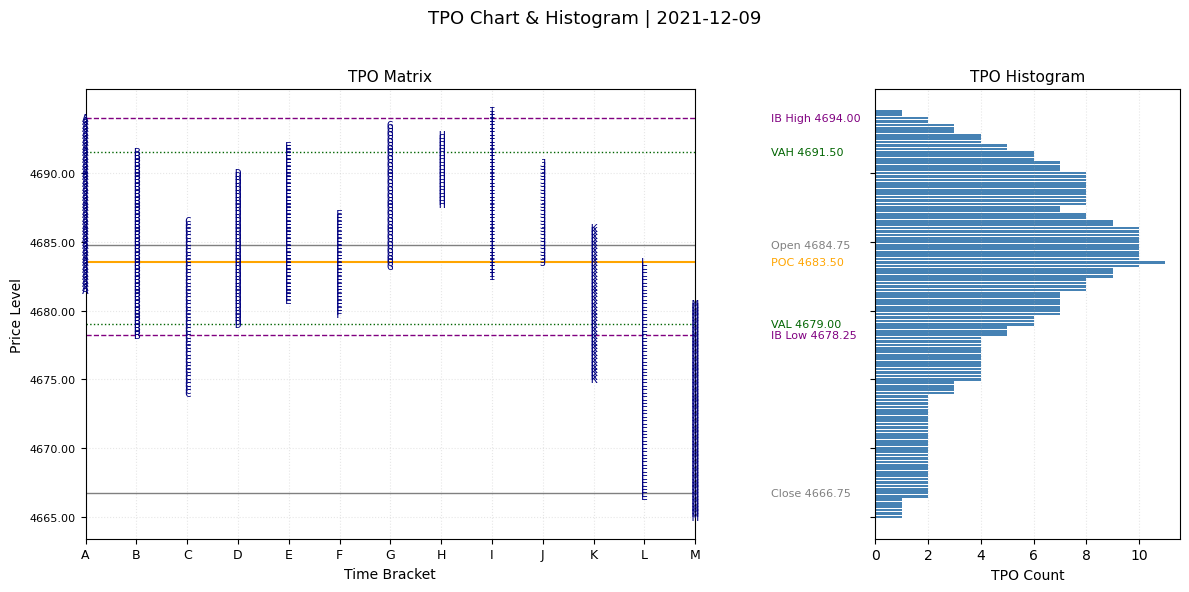


--- NORMAL VARIATION ---


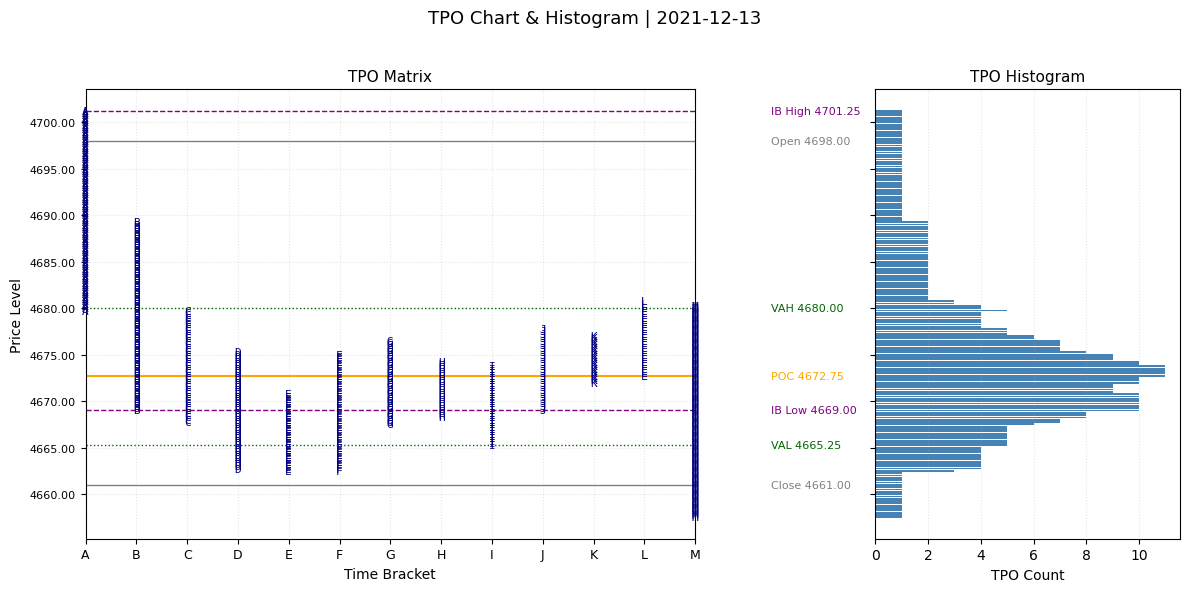


--- TREND ---


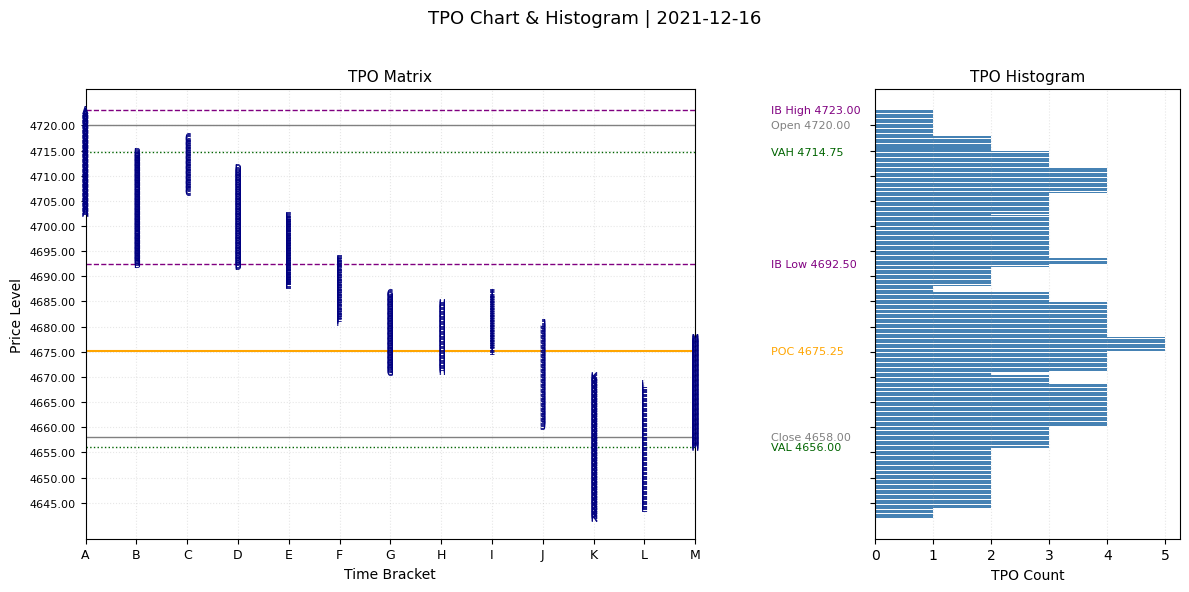


--- NORMAL - CLOSE EXTREME ---


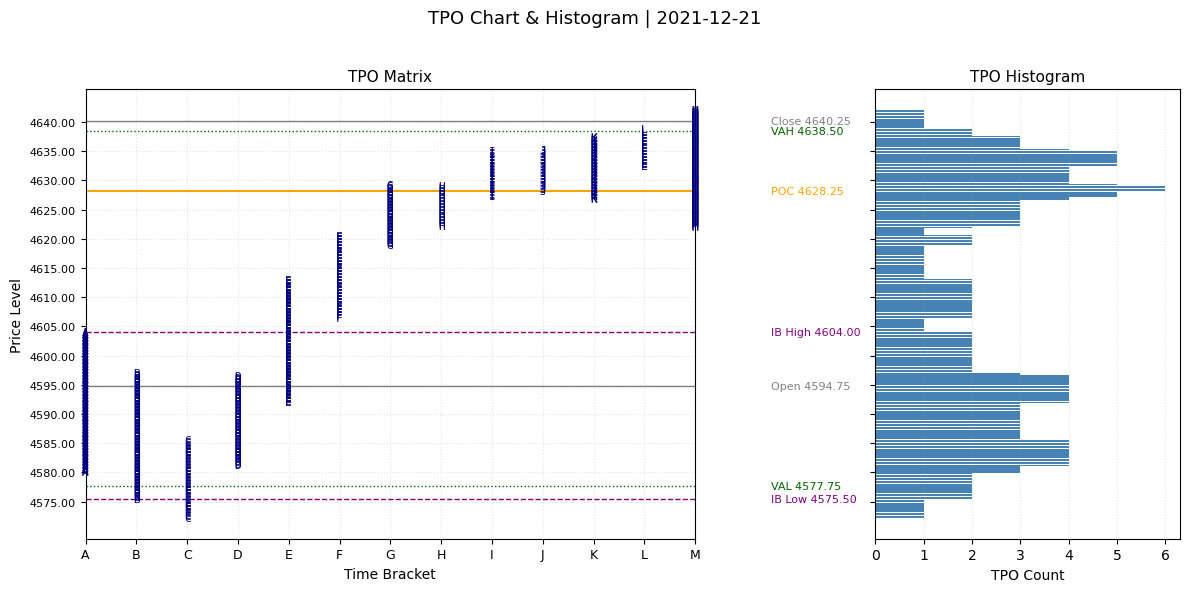


--- DOUBLE DISTRIBUTION - RANGE > 40 ---


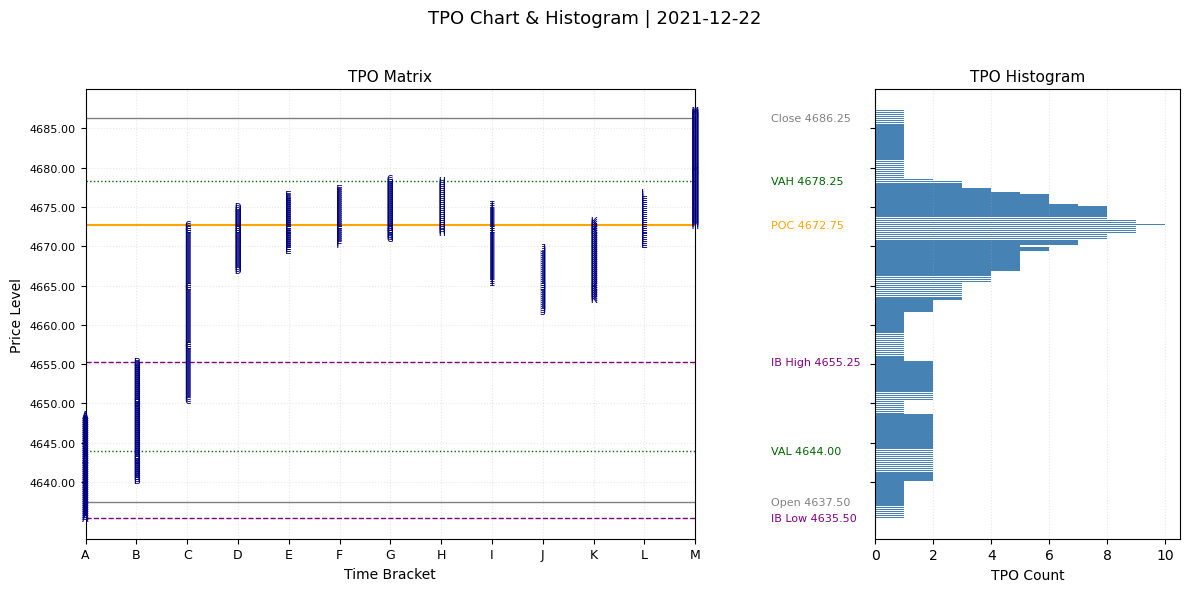


--- MODEST DOUBLE DISTRIBUTION - RANGE < 40 ---


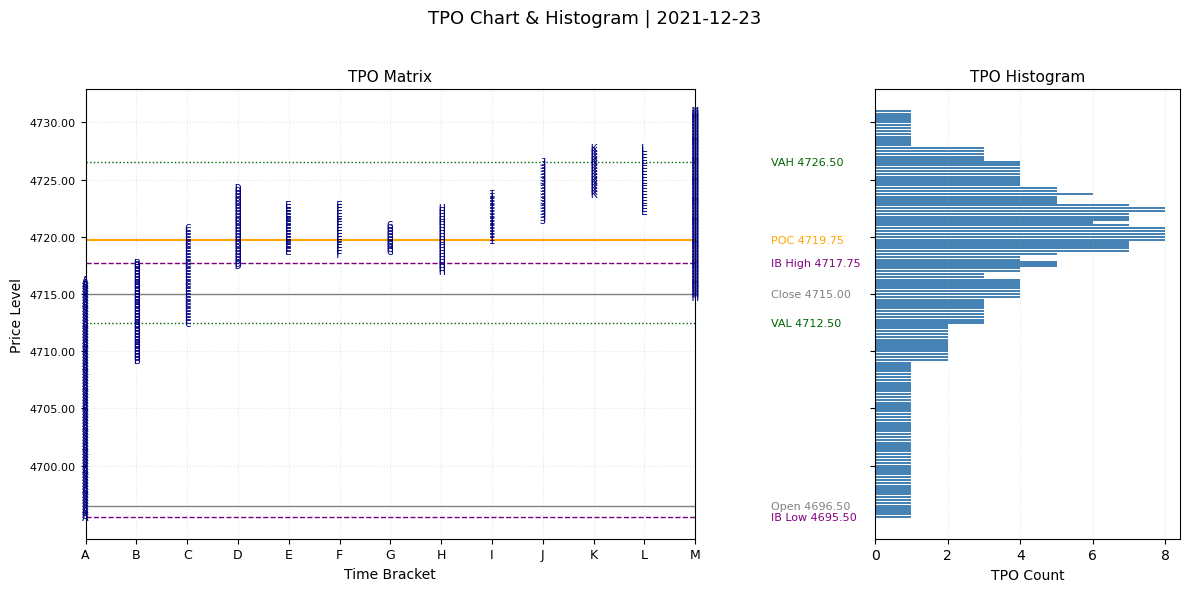


--- NON TREND RANGE < 25 ---


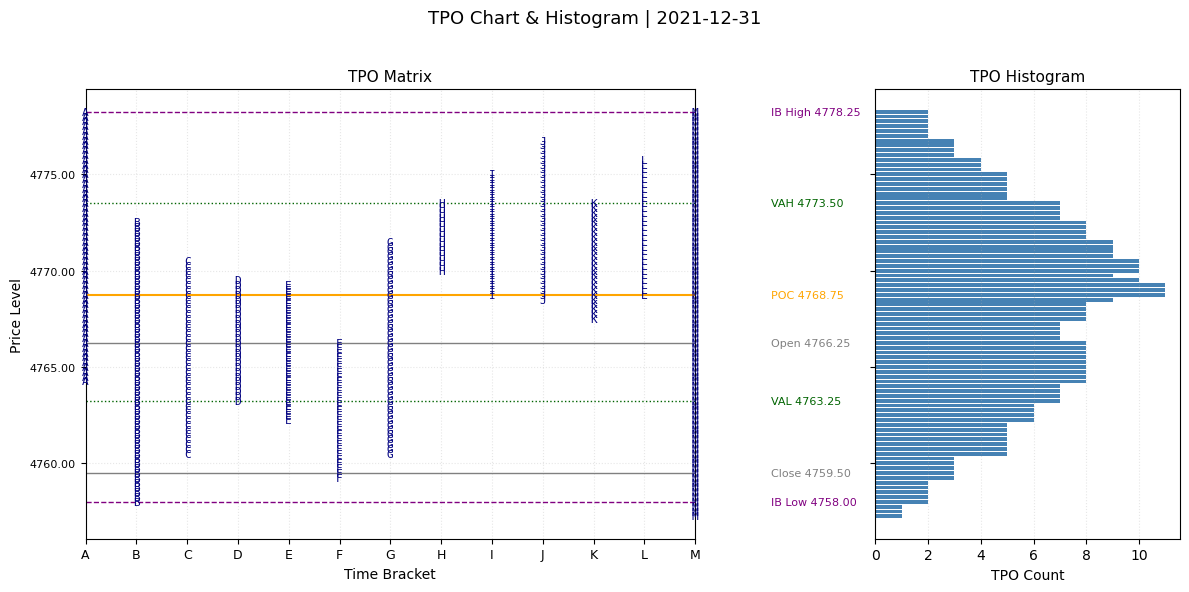


--- NORMAL - CLOSE CENTRAL ---


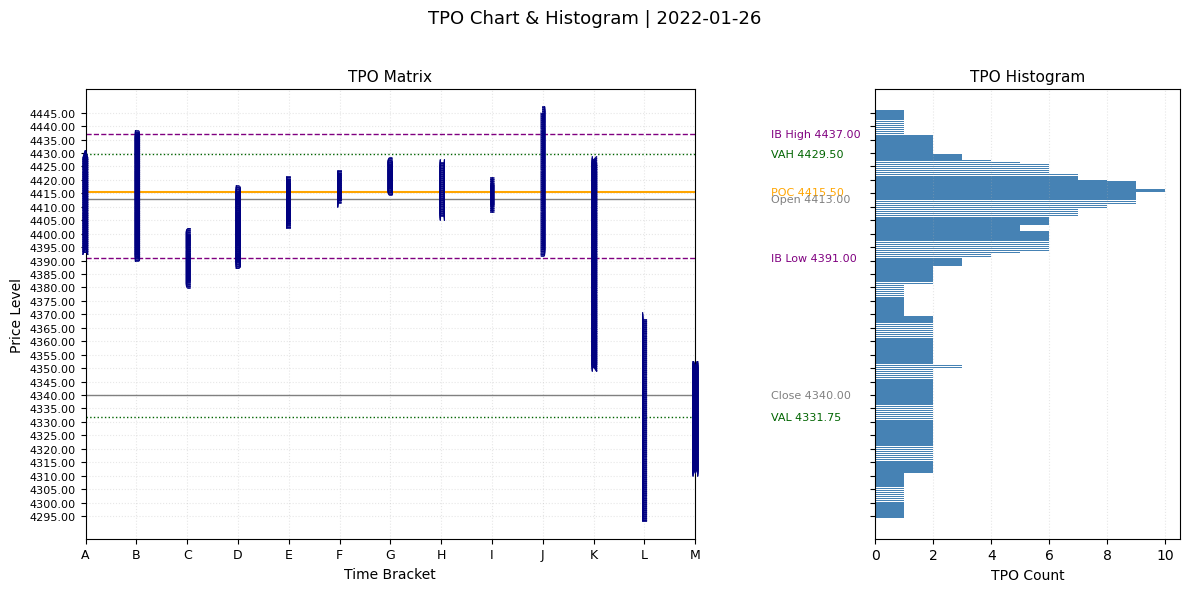


--- MODEST NORMAL - CLOSE CENTRAL ---


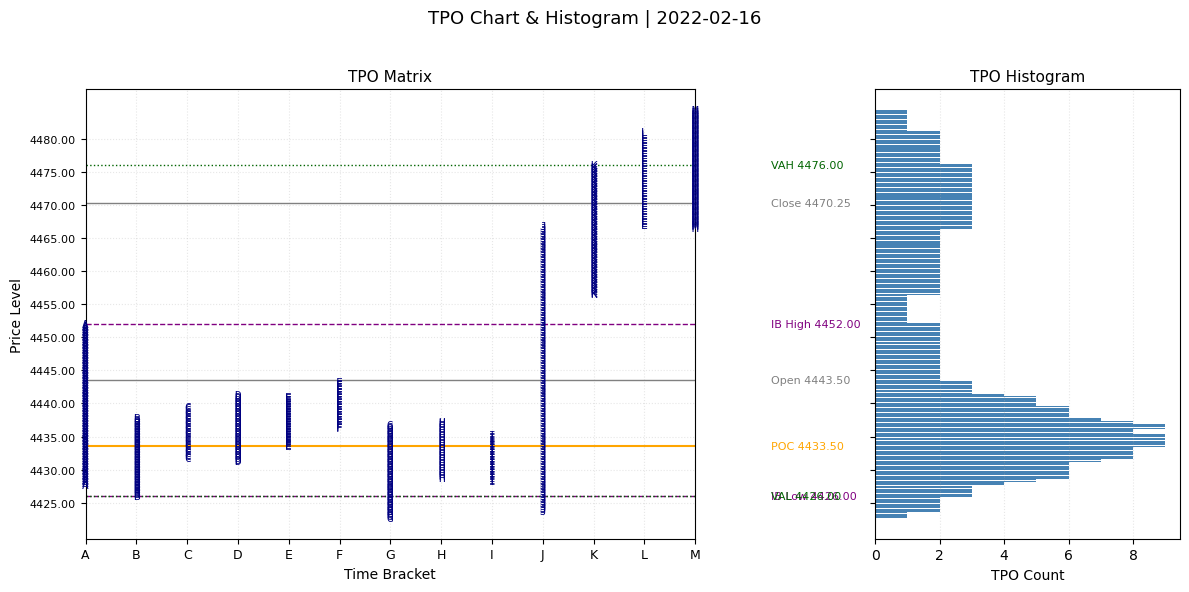


--- INSIDE IB - CLOSE CENTRAL ---


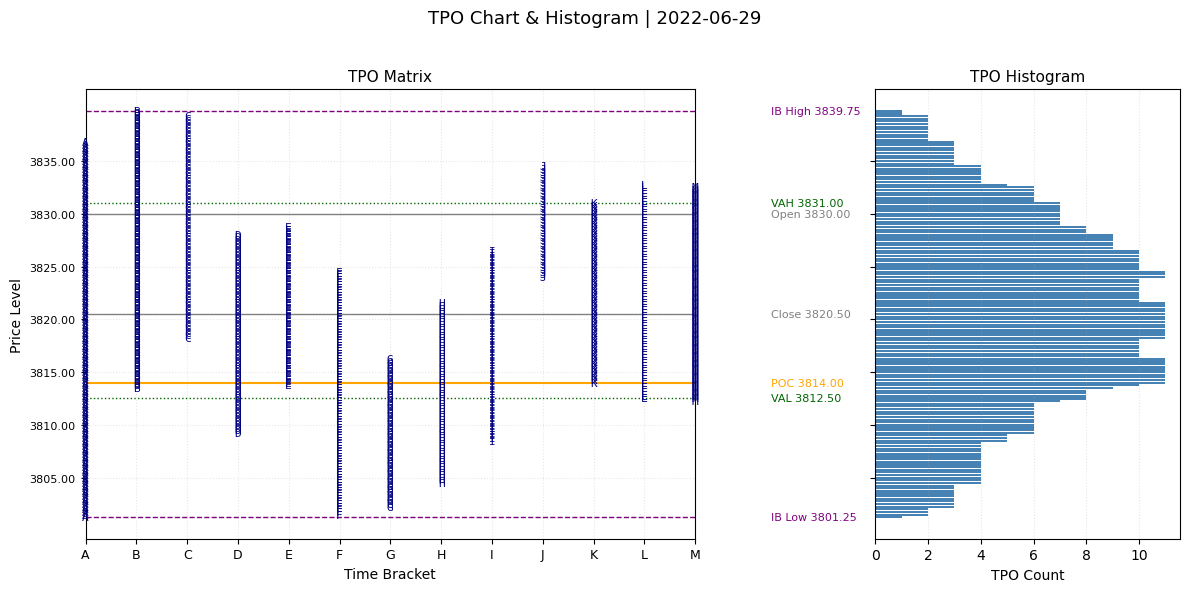


--- INSIDE IB - CLOSE EXTREME ---


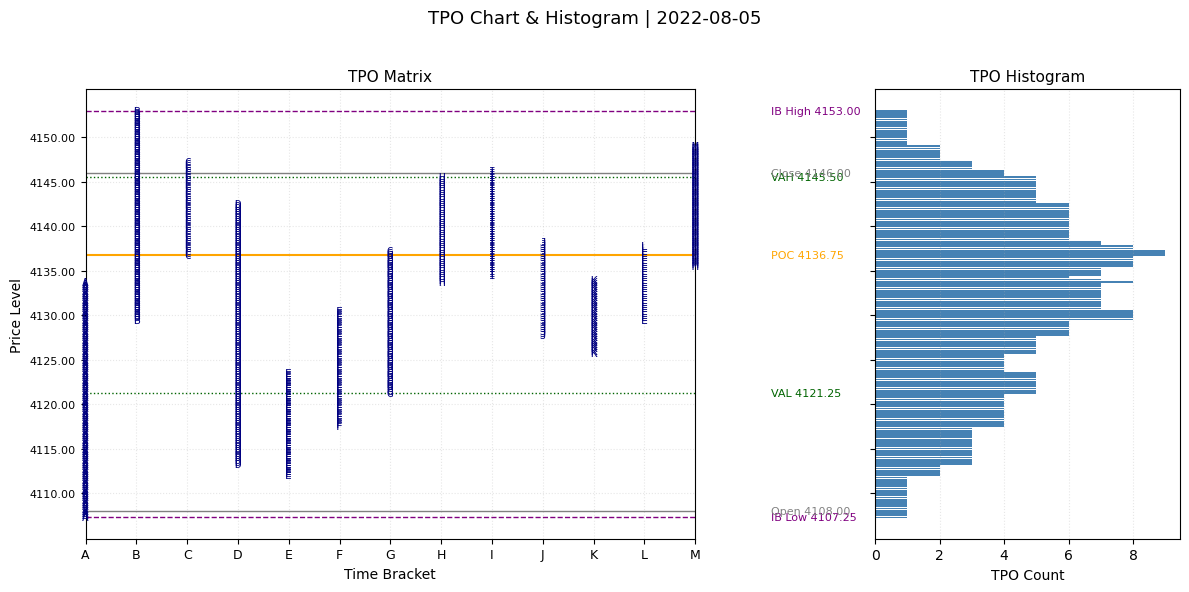

In [34]:
for label in summary:
    print(f"\n--- {label.upper()} ---")
    for date, dtype in day_types.items():
        if dtype == label:
            result = build_tpo_distribution(df, date)
            if result:
                price_levels, tpo_counts, tpo_matrix = result
                plot_tpo_chart(tpo_matrix, tpo_counts, price_levels, date)
            break  # Show one sample per type